# JupyterLab Tutorial

## Terminology
Notebook: .ipynb file that integrates code and its output into a single document that combines visualizations, narrative text, mathematical equations, and other rich media

Kernel: a “computational engine” that executes the code contained in a notebook document.

Cell: a container for text to be displayed in the notebook or code to be executed by the notebook’s kernel.
- Code
- Markdown (HTML)

## Data Exploration

#### Import packages

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six
import os 
import math

#### Load Raw Data

In [49]:
def combineCSVs(datafolder):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                data.append(df)

        input_frame = pd.concat(data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            input_frame = pd.read_csv(datafolder, index_col=None, header=0)
 
    return input_frame


#### Viewing Data in Pandas DataFrame

In [50]:
path = "/Users/prachi/Documents/depth_duration/analysis/data"

df_data = combineCSVs(path)

df_data[0:5]

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,trial,stimulus,duration,actual_depth,depth_estimate,trial_RT,log_sceneDuration,unitSelection,experimentTime,totalTime
0,458329,DepthScenes,duration_manipulation,sequence_N1,http://18.206.127.141/DepthDuration/depth_dura...,1,1280,582,1280,720,...,1,depth_duration_stimuli/001714_6/001714_6-targe...,250,3.128,4.0,3637,251,feet,903324,1020513
1,458329,DepthScenes,duration_manipulation,sequence_N1,http://18.206.127.141/DepthDuration/depth_dura...,1,1280,582,1280,720,...,2,depth_duration_stimuli/002907_4/002907_4-targe...,750,1.938,2.0,5142,750,feet,903324,1020513
2,458329,DepthScenes,duration_manipulation,sequence_N1,http://18.206.127.141/DepthDuration/depth_dura...,1,1280,582,1280,720,...,3,depth_duration_stimuli/003292_3/003292_3-targe...,500,4.488,4.0,4692,499,feet,903324,1020513
3,458329,DepthScenes,duration_manipulation,sequence_N1,http://18.206.127.141/DepthDuration/depth_dura...,1,1280,582,1280,720,...,4,depth_duration_stimuli/002471_8/002471_8-targe...,500,1.131,1.0,5203,500,feet,903324,1020513
4,458329,DepthScenes,duration_manipulation,sequence_N1,http://18.206.127.141/DepthDuration/depth_dura...,1,1280,582,1280,720,...,5,depth_duration_stimuli/000743_13/000743_13-tar...,1000,3.325,3.0,4131,1000,feet,903324,1020513


#### Data Preprocessing

In [51]:
def feet_to_meters(ft):
    """
    Args: 
        ft = float value in feet 
        
    returns:
        m = float value converted to meters 
    """
    m = ft * 0.3048
    return m

def getUnitConveredData(datafolder):
    """
    Converts all estimates to meters 
    """
    input_data = combineCSVs(datafolder) # combine CSVs from all participants 
    
    for idx, row in input_data.iterrows():
        unit = row['unitSelection']
        # if estimate was made in feet, convert to meters 
        if unit == 'feet':
            estim_ft = row['depth_estimate']
            estim_m = feet_to_meters(estim_ft)
            # update depth estimates in existing dataframe
            input_data.at[idx, 'depth_estimate'] = estim_m
            # update units in existing dataframe
            input_data.at[idx, 'unitSelection'] = 'meters'
    
    return input_data

def removeMissedTrials(datafolder):
    """
    Participants were told that if they missed a trial, to respond '0'.
    This function removes those trials, and keeps track of:
    (1) How many missed trials per participant
    (2) Number of missed trials per duration 
    (3) Number of missed trials per sequence 
    """
    input_data = getUnitConveredData(datafolder)
    
    missedTrials_participants = {}
    missedTrials_durations = {}
    missedTrials_sequences = {}
    
    
    for idx, row in input_data.iterrows():
        estimate = row['depth_estimate']
        if estimate == 0.0:
            subjID = row['subjID']
            duration = row['duration']
            sequenceName = row['sequenceName']
            
            if subjID not in missedTrials_participants:
                missedTrials_participants[subjID] = 1
            else:
                missedTrials_participants[subjID] += 1

            if duration not in missedTrials_durations:
                missedTrials_durations[duration] = 1
            else:
                missedTrials_durations[duration] += 1
            
            if sequenceName not in missedTrials_sequences:
                missedTrials_sequences[sequenceName] = 1
            else:
                missedTrials_sequences[sequenceName] += 1
                        
            # remove trials with depth estimate = 0 
            input_data.drop(idx, inplace=True)
    
    return input_data

def durationDfs(datafolder):
    """
    Seperate the the data into seperate dataframes for each duration condition
    """
    
    cleaned_data = removeMissedTrials(datafolder)
    
    data_250ms = cleaned_data[cleaned_data['duration'] == 250.0]
    data_500ms = cleaned_data[cleaned_data['duration'] == 500.0]
    data_750ms = cleaned_data[cleaned_data['duration'] == 750.0]
    data_1000ms = cleaned_data[cleaned_data['duration'] == 1000.0]
    
    return [data_250ms, data_500ms, data_750ms, data_1000ms]

#### Render Formatted Data Table

<AxesSubplot:>

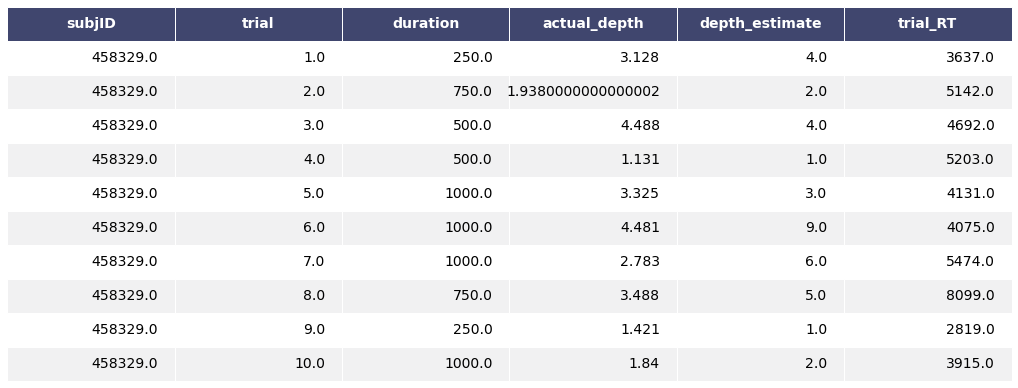

In [52]:
def render_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Args:
        Table formatting parameters 
        Input data 
    Returns:
        Formatted table with columns dropped 
    
    """
    data = data.drop(['stimulus' , 'sequenceName', 'experimentName', 'versionName', 'url', 'selected_row', 'windowWidth', 'windowHeight', 'screenWidth', 'screenHeight', 'startDate', 'startTime', 'log_sceneDuration', 'experimentTime', 'totalTime', 'unitSelection'], axis=1)
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

path = "/Users/prachi/Documents/depth_duration/analysis/data"
rawdata_head = combineCSVs(path)[:10]


render_table(rawdata_head, header_columns=0, col_width=3.0)

<AxesSubplot:>

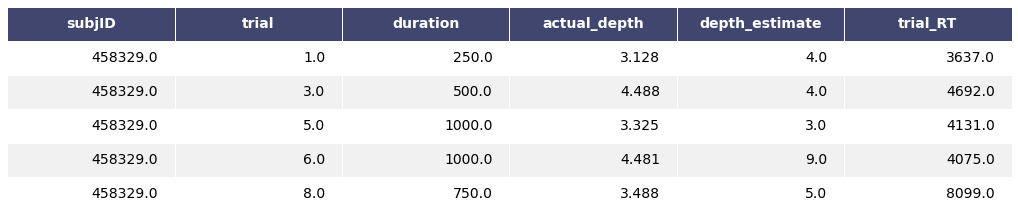

In [53]:
# Filter table by actual depth
rawdata_3m = rawdata_head.loc[rawdata_head['actual_depth'] > 3]
render_table(rawdata_3m, header_columns=0, col_width=3.0)

### Matplotlib Example

In [54]:
import matplotlib.pyplot as plt

a = 1
b = 1
c = -6
#To create an array x consisting of, for example, 100 equally spaced points between -4 and 4, use the linspace command
x = np.linspace(-4, 4, 100)
y = a * x ** 2 + b * x + c  # Compute y for all x values


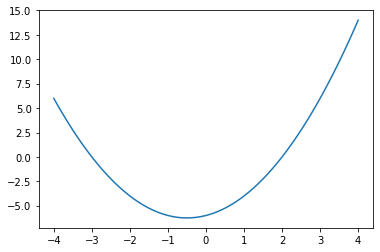

In [55]:
plt.plot(x, y)

### Create CSV

In [56]:
def export_to_CSV(df, destination, name):
    """
    Args:
        df - input pandas dataframe 
        destination - path for csv 
        name - filename 
    
    """
    path = destination + "/" + name + "_datatable.csv"
    
    try:
        df.to_csv(path, index=False)
    except:
        print("Failed to create csv")
        
rawdata_head = combineCSVs(path)[:10]
destination = "/Users/prachi/Documents/depth_duration"

export_to_CSV(rawdata_head, destination, 'example')